In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from sklearn.mixture import GaussianMixture

In [3]:
data = pd.read_csv('FinalDataframe_3.csv')

In [34]:
## have to also drop na
data = data.dropna()

In [73]:
data

,Unnamed: 0,Unnamed: 0.1,fips_final,NAME,num_hospitals,num_licensed_beds,num_staffed_beds,num_icu_beds,adult_icu_beds,pedi_icu_beds,...,75+,num_hospitals_pt,num_licensed_beds_pt,num_staffed_beds_pt,num_icu_beds_pt,adult_icu_beds_pt,pedi_icu_beds_pt,potential_increase_in_bed_capac_pt,bed_utilization_pt,avg_ventilator_usage_pt
1,1,1,1003,"Baldwin County, Alabama",4,386,362,51,51,0,...,12765,0.000022,0.002118,0.001986,0.000280,0.000280,0.0,0.000132,0.000003,0.000011
3,3,3,1007,"Bibb County, Alabama",1,35,25,4,4,0,...,1183,0.000044,0.001527,0.001091,0.000175,0.000175,0.0,0.000436,0.000019,0.000044
4,4,4,1009,"Blount County, Alabama",1,25,25,6,6,0,...,3360,0.000017,0.000436,0.000436,0.000105,0.000105,0.0,0.000000,0.000009,0.000035
6,6,6,1013,"Butler County, Alabama",1,72,44,7,7,0,...,1660,0.000048,0.003437,0.002101,0.000334,0.000334,0.0,0.001337,0.000009,0.000095
7,7,7,1015,"Calhoun County, Alabama",3,486,435,30,30,0,...,7553,0.000025,0.004099,0.003669,0.000253,0.000253,0.0,0.000430,0.000004,0.000042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,2289,2289,56013,"Fremont County, Wyoming",1,146,133,12,12,0,...,2552,0.000025,0.003639,0.003315,0.000299,0.000299,0.0,0.000324,0.000003,0.000050
2292,2292,2292,56019,"Johnson County, Wyoming",1,25,22,4,4,0,...,704,0.000117,0.002917,0.002567,0.000467,0.000467,0.0,0.000350,0.000032,0.000117
2293,2293,2293,56021,"Laramie County, Wyoming",1,206,170,15,15,0,...,5064,0.000011,0.002246,0.001853,0.000164,0.000164,0.0,0.000392,0.000006,0.000044
2294,2294,2294,56023,"Lincoln County, Wyoming",2,38,35,8,8,0,...,869,0.000110,0.002099,0.001933,0.000442,0.000442,0.0,0.000166,0.000012,0.000110


In [67]:
for col in data.columns: 
    print(col) 

Unnamed: 0
Unnamed: 0.1
fips_final
NAME
num_hospitals
num_licensed_beds
num_staffed_beds
num_icu_beds
adult_icu_beds
pedi_icu_beds
potential_increase_in_bed_capac
bed_utilization
avg_ventilator_usage
population
cases_total
deaths_total
cases_per_capita
deaths_per_capita
case_fatality_rate
Unnamed: 0.1.1
county
STATEFP
COUNTYFP
CountyName
StateName
State
dem_to_rep_ratio
stay.at.home
X.50.gatherings
X.500.gatherings
public.schools
restaurant.dine.in
entertainment.gym
federal.guidelines
foreign.travel.ban
Total!!Male
Total!!Female
Total
Total!!Population of one race
Total!!Population of one race!!White
Total!!Population of one race!!Black or African American
Total!!Population of one race!!American Indian and Alaska Native
Total!!Population of one race!!Asian
Total!!Population of one race!!Asian!!Asian Indian
Total!!Population of one race!!Asian!!Chinese (including Taiwanese)
Total!!Population of one race!!Asian!!Filipino
Total!!Population of one race!!Asian!!Japanese
Total!!Population of

In [72]:
## build per capita 
data['num_hospitals_pt'] = data['num_hospitals'] / data['Total']
data['num_licensed_beds_pt'] = data['num_licensed_beds'] / data['Total']
data['num_staffed_beds_pt'] = data['num_staffed_beds'] / data['Total']
data['num_icu_beds_pt'] = data['num_icu_beds'] / data['Total']
data['adult_icu_beds_pt'] = data['adult_icu_beds'] / data['Total']
data['pedi_icu_beds_pt'] = data['pedi_icu_beds'] / data['Total']
data['potential_increase_in_bed_capac_pt'] = data['potential_increase_in_bed_capac'] / data['Total']
data['bed_utilization_pt'] = data['bed_utilization'] / data['Total']
data['avg_ventilator_usage_pt'] = data['avg_ventilator_usage'] / data['Total']

/Users/liuyuning/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/liuyuning/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/liuyuning/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [87]:
#for X, or what we're clustering, we are removing outcomes y, such as case and death totals
#Also removing strings; can't k-means cluster on these
#Also removing columns Unnamed, they seem to be artifacts from data cleaning/combining multiple datasets?
X = data.drop(['Unnamed: 0', 'Unnamed: 0.1','NAME',  'cases_total', 'fips_final',
       'deaths_total', 'cases_per_capita', 'deaths_per_capita',
       'case_fatality_rate', 'Unnamed: 0.1.1', 'county', 'population','STATEFP', 'COUNTYFP',
       'CountyName', 'StateName', 'State','num_hospitals', 'num_licensed_beds','num_staffed_beds','num_icu_beds',
        'adult_icu_beds','pedi_icu_beds', 'potential_increase_in_bed_capac','bed_utilization','avg_ventilator_usage',
         'federal.guidelines',   'foreign.travel.ban'  ], axis=1)
y = data[["cases_total", "deaths_total", "cases_per_capita", "deaths_per_capita", "case_fatality_rate"]]

In [93]:
## standardize
X_n = (X - X.mean(axis=0)) / X.std(axis=0)

## K-Means

In [94]:
#set number of clusters
kmeans = KMeans(n_clusters=4, random_state=0).fit(X_n)

#Run the clustering algorithm
model = kmeans.fit(X_n)
model

#Generate cluster predictions and store in y_hat
y_hat = kmeans.predict(X_n)

In [95]:
#function that creates a dataframe with a column for cluster number
cluster_centers = kmeans.cluster_centers_

def kmean_col(X, cluster_centers):
        cols = list(X)
        cols.append('cluster')
        
# Zip with a column called 'cluster' (index)
        Z = [np.append(A, index) for index, A in enumerate(cluster_centers)]
    
# Convert to pandas data frame for plotting
        P = pd.DataFrame(Z, columns=cols)
        P['cluster'] = P['cluster'].astype(int)
        return P
    
P = kmean_col(X_n, cluster_centers)
P

,dem_to_rep_ratio,stay.at.home,X.50.gatherings,X.500.gatherings,public.schools,restaurant.dine.in,entertainment.gym,Total!!Male,Total!!Female,Total,...,num_hospitals_pt,num_licensed_beds_pt,num_staffed_beds_pt,num_icu_beds_pt,adult_icu_beds_pt,pedi_icu_beds_pt,potential_increase_in_bed_capac_pt,bed_utilization_pt,avg_ventilator_usage_pt,cluster
0,0.252231,-0.239376,-0.253843,-0.197091,-0.121653,-0.301636,-0.264806,0.092225,0.092205,0.092228,...,-0.334367,0.090812,0.135607,-0.043631,-0.043631,0.401160,-0.043264,-0.314905,-0.374769,0
1,-0.296509,0.208971,0.175784,0.128544,0.062402,0.213020,0.204969,-0.373843,-0.375159,-0.374570,...,0.242373,-0.063378,-0.096096,0.012266,0.012266,-0.315988,0.032942,0.229762,0.306527,1
2,1.266889,-0.593479,-0.318390,-0.183009,0.000798,-0.372105,-0.463638,2.023297,2.051097,2.037786,...,-0.486620,0.147335,0.211845,0.113084,0.113084,0.807870,-0.054779,-0.469104,-0.815283,2
3,1.361793,-0.935302,-0.205416,-0.101097,0.237574,-0.574536,-0.698690,6.877754,6.758559,6.817905,...,-0.503647,-0.145502,-0.055929,-0.074761,-0.074761,0.636201,-0.235225,-0.495150,-0.912084,3


## EM

In [96]:
## run the EM algorithm (note i have to increase the reg-covar here)
em_k = GaussianMixture(n_components=4, init_params='kmeans', random_state=10, reg_covar = 1e-4).fit(X_n)

In [97]:
#Generate cluster predictions and store in y_hat
y_hat = em_k.predict(X_n)

In [98]:
#combining cluster data with outcome data to look at the whole dataset...
X_n['label_2'] = y_hat # result for EM

X_n['label'] = kmeans.labels_ # result for K-means
whole = pd.concat([X_n, y], axis=1)

In [99]:
whole

,dem_to_rep_ratio,stay.at.home,X.50.gatherings,X.500.gatherings,public.schools,restaurant.dine.in,entertainment.gym,Total!!Male,Total!!Female,Total,...,potential_increase_in_bed_capac_pt,bed_utilization_pt,avg_ventilator_usage_pt,label_2,label,cases_total,deaths_total,cases_per_capita,deaths_per_capita,case_fatality_rate
1,-0.564591,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,-0.046878,-0.044805,-0.045827,...,-0.430859,-0.339586,-0.737095,1,0,188,4,0.000842,0.000018,0.021276596
3,-0.539953,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,-0.460164,-0.469788,-0.465145,...,-0.086634,0.528261,-0.058992,1,1,42,0,0.001876,0.000000,0
4,-0.722049,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,-0.373842,-0.375230,-0.374605,...,-0.579607,-0.029220,-0.240605,1,1,40,0,0.000692,0.000000,0
6,-0.062311,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,-0.473402,-0.467236,-0.470323,...,0.930402,-0.016734,1.017112,1,1,114,1,0.005862,0.000051,0.00877193
7,-0.416318,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,-0.218976,-0.208051,-0.213430,...,-0.093725,-0.308938,-0.089529,1,1,105,3,0.000924,0.000026,0.028571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,-0.442881,0.033195,-0.175407,0.359231,1.011650,0.169535,-0.272462,-0.418623,-0.420932,-0.419863,...,-0.213597,-0.332612,0.069859,0,1,128,4,0.003260,0.000102,0.03125
2292,-0.633705,0.033195,-0.175407,0.359231,1.011650,0.169535,-0.272462,-0.502818,-0.502825,-0.502895,...,-0.184118,1.264053,1.457618,1,1,11,1,0.001303,0.000118,0.090909091
2293,-0.354053,0.033195,-0.175407,0.359231,1.011650,0.169535,-0.272462,-0.279715,-0.288110,-0.284042,...,-0.136308,-0.200939,-0.059762,1,1,104,1,0.001045,0.000010,0.009615385
2294,-0.654003,0.033195,-0.175407,0.359231,1.011650,0.169535,-0.272462,-0.476283,-0.479116,-0.477799,...,-0.392435,0.138033,1.328104,1,1,6,0,0.000303,0.000000,0


In [100]:
#creates a dataframe with a column for cluster number
b = pd.DataFrame()
for col in X_n.drop(['label_2'],axis=1).columns: 
    a = whole.groupby('label_2', as_index=False).agg({col: "mean"})
    b = pd.concat([b, a], axis=1)

In [101]:
b

,label_2,dem_to_rep_ratio,label_2,stay.at.home,label_2,X.50.gatherings,label_2,X.500.gatherings,label_2,public.schools,...,label_2,pedi_icu_beds_pt,label_2,potential_increase_in_bed_capac_pt,label_2,bed_utilization_pt,label_2,avg_ventilator_usage_pt,label_2,label
0,0,0.277440,0,-0.113277,0,-0.155366,0,-0.118014,0,-0.061662,...,0,0.555263,0,-0.039052,0,-0.344502,0,-0.391612,0,0.222615
1,1,-0.271597,1,0.132820,1,0.113004,1,0.076160,1,0.021814,...,1,-0.323642,1,0.028895,1,0.204394,1,0.267484,1,0.840121
2,2,1.361793,2,-0.935302,2,-0.205416,2,-0.101097,2,0.237574,...,2,0.636201,2,-0.235225,2,-0.495150,2,-0.912084,2,3.000000
3,3,1.240237,3,-0.660894,3,-0.404224,3,-0.224811,3,0.011802,...,3,0.718184,3,-0.083175,3,-0.466152,3,-0.809816,3,1.833333


In [102]:
## counts_1 is the label result for K-means, counts_2 is the label result for EM
counts_1 = whole['label'].value_counts() # kmeans
counts_2 = whole['label_2'].value_counts() #EM

In [103]:
counts_1

1    616
0    334
2     68
3      9
Name: label, dtype: int64

In [104]:
counts_2

1    663
0    283
3     72
2      9
Name: label_2, dtype: int64

In [105]:
c = data[['num_hospitals', 'num_licensed_beds','num_staffed_beds','num_icu_beds',
        'adult_icu_beds','pedi_icu_beds', 'potential_increase_in_bed_capac','bed_utilization','avg_ventilator_usage']]

In [106]:
whole_2 = pd.concat([whole, c], axis=1)

In [107]:
whole_2

,dem_to_rep_ratio,stay.at.home,X.50.gatherings,X.500.gatherings,public.schools,restaurant.dine.in,entertainment.gym,Total!!Male,Total!!Female,Total,...,case_fatality_rate,num_hospitals,num_licensed_beds,num_staffed_beds,num_icu_beds,adult_icu_beds,pedi_icu_beds,potential_increase_in_bed_capac,bed_utilization,avg_ventilator_usage
1,-0.564591,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,-0.046878,-0.044805,-0.045827,...,0.021276596,4,386,362,51,51,0,24,0.562203,2.0
3,-0.539953,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,-0.460164,-0.469788,-0.465145,...,0,1,35,25,4,4,0,10,0.430904,1.0
4,-0.722049,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,-0.373842,-0.375230,-0.374605,...,0,1,25,25,6,6,0,0,0.499069,2.0
6,-0.062311,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,-0.473402,-0.467236,-0.470323,...,0.00877193,1,72,44,7,7,0,28,0.187111,2.0
7,-0.416318,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,-0.218976,-0.208051,-0.213430,...,0.028571429,3,486,435,30,30,0,51,0.431563,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,-0.442881,0.033195,-0.175407,0.359231,1.011650,0.169535,-0.272462,-0.418623,-0.420932,-0.419863,...,0.03125,1,146,133,12,12,0,13,0.128829,2.0
2292,-0.633705,0.033195,-0.175407,0.359231,1.011650,0.169535,-0.272462,-0.502818,-0.502825,-0.502895,...,0.090909091,1,25,22,4,4,0,3,0.275342,1.0
2293,-0.354053,0.033195,-0.175407,0.359231,1.011650,0.169535,-0.272462,-0.279715,-0.288110,-0.284042,...,0.009615385,1,206,170,15,15,0,36,0.513360,4.0
2294,-0.654003,0.033195,-0.175407,0.359231,1.011650,0.169535,-0.272462,-0.476283,-0.479116,-0.477799,...,0,2,38,35,8,8,0,3,0.212492,2.0


In [108]:
whole_2.to_csv('FinalDataframe_with_cluster_2.csv')

In [15]:
data = pd.read_csv("FinalDataframe_with_cluster_2.csv")

In [16]:
outcome = data

In [17]:
km_0 = data[data["label"]==0]
km_0

,Unnamed: 0,dem_to_rep_ratio,stay.at.home,X.50.gatherings,X.500.gatherings,public.schools,restaurant.dine.in,entertainment.gym,Total!!Male,Total!!Female,...,case_fatality_rate,num_hospitals,num_licensed_beds,num_staffed_beds,num_icu_beds,adult_icu_beds,pedi_icu_beds,potential_increase_in_bed_capac,bed_utilization,avg_ventilator_usage
0,1,-0.564591,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,-0.046878,-0.044805,...,0.021276596,4,386,362,51,51,0,24,0.562203,2.000000
19,30,-0.471674,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,-0.264316,-0.252320,...,0.041237113,4,744,666,72,72,22,78,0.746111,4.500000
21,32,0.337700,-0.354204,-0.175407,-1.090803,-0.846132,0.169535,1.645564,1.149617,1.262195,...,0.048387097,13,4455,3687,393,393,264,768,0.629684,7.076923
25,37,-0.120255,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,0.356889,0.354236,...,0.016877637,4,1151,1150,83,83,49,1,0.665045,6.000000
28,41,-0.063626,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,0.539918,0.581672,...,0.05400982,6,1870,1464,246,246,118,406,0.742569,5.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,2271,-0.114819,-0.547903,-0.985645,-0.262212,0.082759,-0.574536,-0.698690,-0.214493,-0.228147,...,0.037735849,2,370,189,13,13,6,181,0.341329,2.000000
1016,2278,-0.264953,-0.547903,-0.985645,-0.262212,0.082759,-0.574536,-0.698690,0.502193,0.498783,...,0.054495913,8,1070,710,64,64,34,360,0.583727,2.000000
1017,2281,0.029409,-0.547903,-0.985645,-0.262212,0.082759,-0.574536,-0.698690,-0.075063,-0.096486,...,0.013888889,5,795,687,60,60,0,108,0.460244,2.800000
1018,2282,-0.159788,-0.547903,-0.985645,-0.262212,0.082759,-0.574536,-0.698690,-0.328614,-0.328781,...,0,3,619,262,16,16,26,357,0.669993,3.000000


In [18]:
km0_X = km_0.drop(['Unnamed: 0', 'cases_total', 
       'deaths_total', 'cases_per_capita', 'deaths_per_capita',
       'case_fatality_rate', 'num_hospitals', 'num_licensed_beds','num_staffed_beds','num_icu_beds',
        'adult_icu_beds','pedi_icu_beds', 'potential_increase_in_bed_capac','bed_utilization','avg_ventilator_usage',
                 "label", "label_2"], axis=1)
km0_y = km_0["cases_per_capita"]

In [19]:
km0_y

0       0.000842
19      0.000916
21      0.001506
25      0.000636
28      0.002957
          ...   
1013    0.000460
1016    0.000908
1017    0.000419
1018    0.000027
1019    0.000206
Name: cases_per_capita, Length: 334, dtype: float64

In [20]:
km0_X

,dem_to_rep_ratio,stay.at.home,X.50.gatherings,X.500.gatherings,public.schools,restaurant.dine.in,entertainment.gym,Total!!Male,Total!!Female,Total,...,75+,num_hospitals_pt,num_licensed_beds_pt,num_staffed_beds_pt,num_icu_beds_pt,adult_icu_beds_pt,pedi_icu_beds_pt,potential_increase_in_bed_capac_pt,bed_utilization_pt,avg_ventilator_usage_pt
0,-0.564591,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,-0.046878,-0.044805,-0.045827,...,0.041416,-0.295633,-0.368365,-0.228826,-0.015193,-0.015193,-0.466281,-0.430859,-0.339586,-0.737095
19,-0.471674,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,-0.264316,-0.252320,-0.258230,...,-0.252106,0.065068,2.143912,2.507679,1.917899,1.917899,1.628830,0.288095,-0.104244,-0.044982
21,0.337700,-0.354204,-0.175407,-1.090803,-0.846132,0.169535,1.645564,1.149617,1.262195,1.207261,...,1.420617,-0.341189,1.873370,1.933640,1.412626,1.412626,3.410953,0.737955,-0.457079,-0.741775
25,-0.120255,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,0.356889,0.354236,0.355587,...,0.273917,-0.502383,0.268265,0.638166,-0.158914,-0.158914,0.949017,-0.576233,-0.400214,-0.592876
28,-0.063626,1.389090,-0.175407,-1.090803,-0.846132,0.169535,1.645564,0.539918,0.581672,0.561314,...,0.537234,-0.449014,0.794064,0.704052,1.407273,1.407273,2.296788,0.530916,-0.410610,-0.705184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,-0.114819,-0.547903,-0.985645,-0.262212,0.082759,-0.574536,-0.698690,-0.214493,-0.228147,-0.221496,...,-0.163552,-0.391391,0.155168,-0.438207,-0.768513,-0.768513,0.036055,1.190558,-0.346734,-0.605447
1016,-0.264953,-0.547903,-0.985645,-0.262212,0.082759,-0.574536,-0.698690,0.502193,0.498783,0.500526,...,0.705993,-0.325150,-0.066170,-0.327634,-0.536114,-0.536114,0.377029,0.463437,-0.427220,-0.858395
1017,0.029409,-0.547903,-0.985645,-0.262212,0.082759,-0.574536,-0.698690,-0.075063,-0.096486,-0.086011,...,-0.033067,-0.130318,0.906306,1.044622,0.342773,0.342773,-0.466281,0.150970,-0.357720,-0.616821
1018,-0.159788,-0.547903,-0.985645,-0.262212,0.082759,-0.574536,-0.698690,-0.328614,-0.328781,-0.328747,...,-0.253279,0.080445,2.604223,0.680233,-0.311372,-0.311372,2.897435,4.815577,-0.015042,-0.131755


In [21]:
from sklearn.model_selection import train_test_split
# implementing train-test-split
X_train, X_test, y_train, y_test = train_test_split(km0_X, km0_y, test_size=0.33, random_state=66)

In [29]:
import matplotlib.pyplot as plt

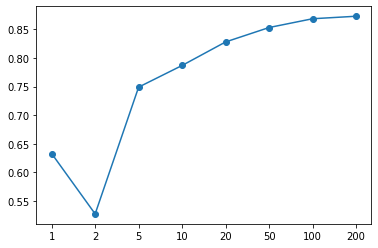

In [30]:
from sklearn.ensemble import RandomForestRegressor

np.random.seed(263)
Bs = [1, 2, 5, 10, 20, 50, 100, 200]
Rsqs = []
for B in Bs:
    regressor1 = RandomForestRegressor(n_estimators=B, max_depth=10)
    regressor1.fit(X_train, y_train)
    Rsqs.append(regressor1.score(X_train, y_train))
# Make the plot
plt.plot(list(map(str, Bs)), Rsqs, "-o")
plt.show()

In [33]:
max_Rsq = max(Rsqs)
max_index = Rsqs.index(max_Rsq)
max_index
B = Bs[max_index]
B

200

In [34]:
regressor1 = RandomForestRegressor(n_estimators=B, max_depth=10)
regressor1.fit(X_train, y_train)
preds = regressor1.predict(X_test)

In [43]:
feature_list = list(km0_X.columns)
# Get numerical feature importances
importances = list(regressor1.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Total!!Population of one race!!Asian!!Asian Indian Importance: 0.24
Variable: Total!!Population of one race!!Asian!!Vietnamese Importance: 0.07
Variable: Total!!Population of one race!!Native Hawaiian and Other Pacific Islander!!Samoan Importance: 0.05
Variable: mob_residential      Importance: 0.05
Variable: dem_to_rep_ratio     Importance: 0.04
Variable: entertainment.gym    Importance: 0.03
Variable: Total!!Population of one race!!Black or African American Importance: 0.03
Variable: Total!!Population of one race!!Asian Importance: 0.03
Variable: Total!!Population of one race!!Asian!!Filipino Importance: 0.03
Variable: Total!!Population of one race!!Native Hawaiian and Other Pacific Islander!!Native Hawaiian Importance: 0.03
Variable: potential_increase_in_bed_capac_pt Importance: 0.03
Variable: Total!!Population of one race!!Asian!!Chinese (including Taiwanese) Importance: 0.02
Variable: Total!!Population of Two or More Races!!White; American Indian and Alaska Native Impor

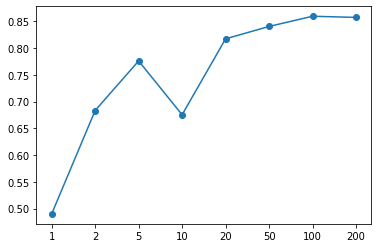


max R squared: 0.8597580419640622
Variable: Total!!Population of one race!!Black or African American Importance: 0.2
Variable: Total!!Population of one race!!Asian!!Other Asian Importance: 0.06
Variable: Total!!Population of one race!!Asian!!Korean Importance: 0.05
Variable: num_staffed_beds_pt  Importance: 0.05
Variable: bed_utilization_pt   Importance: 0.05
Variable: X.50.gatherings      Importance: 0.03
Variable: Total!!Population of one race!!Some Other Race Importance: 0.03
Variable: Total!!Population of Two or More Races!!White; American Indian and Alaska Native Importance: 0.03
Variable: mob_residential      Importance: 0.03
Variable: num_hospitals_pt     Importance: 0.03
Variable: X.500.gatherings     Importance: 0.02
Variable: restaurant.dine.in   Importance: 0.02
Variable: Total!!Population of one race!!American Indian and Alaska Native Importance: 0.02
Variable: Total!!Population of one race!!Asian!!Asian Indian Importance: 0.02
Variable: Total!!Population of one race!!Asia

In [46]:
km_1 = data[data["label"]==1]
km1_X = km_1.drop(['Unnamed: 0', 'cases_total', 
       'deaths_total', 'cases_per_capita', 'deaths_per_capita',
       'case_fatality_rate', 'num_hospitals', 'num_licensed_beds','num_staffed_beds','num_icu_beds',
        'adult_icu_beds','pedi_icu_beds', 'potential_increase_in_bed_capac','bed_utilization','avg_ventilator_usage',
                 "label", "label_2"], axis=1)
km1_y = km_1["cases_per_capita"]
X_train, X_test, y_train, y_test = train_test_split(km1_X, km1_y, test_size=0.33, random_state=66)
np.random.seed(263)
Bs = [1, 2, 5, 10, 20, 50, 100, 200]
Rsqs = []
for B in Bs:
    regressor2 = RandomForestRegressor(n_estimators=B, max_depth=10)
    regressor2.fit(X_train, y_train)
    Rsqs.append(regressor2.score(X_train, y_train))
# Make the plot
plt.plot(list(map(str, Bs)), Rsqs, "-o")
plt.show()
max_Rsq = max(Rsqs)
max_index = Rsqs.index(max_Rsq)
print("\nmax R squared:", max_Rsq)
B = Bs[max_index]
B
regressor2 = RandomForestRegressor(n_estimators=B, max_depth=10)
regressor2.fit(X_train, y_train)
preds = regressor2.predict(X_test)
feature_list = list(km1_X.columns)
# Get numerical feature importances
importances = list(regressor2.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

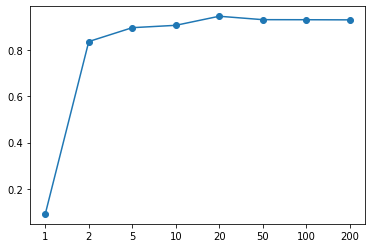


max R squared: 0.945665937030557
Variable: stay.at.home         Importance: 0.29
Variable: Total!!Population of Two or More Races!!White; American Indian and Alaska Native Importance: 0.15
Variable: Total!!Population of one race!!Native Hawaiian and Other Pacific Islander!!Samoan Importance: 0.08
Variable: Total!!Population of one race!!Asian!!Chinese (including Taiwanese) Importance: 0.06
Variable: Total!!Population of one race!!Asian!!Vietnamese Importance: 0.06
Variable: Total!!Population of one race!!Asian!!Japanese Importance: 0.04
Variable: X.50.gatherings      Importance: 0.03
Variable: entertainment.gym    Importance: 0.02
Variable: Total!!Population of one race!!Asian!!Filipino Importance: 0.02
Variable: Total!!Population of one race!!Native Hawaiian and Other Pacific Islander!!Other Pacific Islander Importance: 0.02
Variable: Total!!Population of Two or More Races!!White; Black or African American Importance: 0.02
Variable: Total!!Population of Two or More Races!!White; Some

In [47]:
km_2 = data[data["label"]==2]
km2_X = km_2.drop(['Unnamed: 0', 'cases_total', 
       'deaths_total', 'cases_per_capita', 'deaths_per_capita',
       'case_fatality_rate', 'num_hospitals', 'num_licensed_beds','num_staffed_beds','num_icu_beds',
        'adult_icu_beds','pedi_icu_beds', 'potential_increase_in_bed_capac','bed_utilization','avg_ventilator_usage',
                 "label", "label_2"], axis=1)
km2_y = km_2["cases_per_capita"]
X_train, X_test, y_train, y_test = train_test_split(km2_X, km2_y, test_size=0.33, random_state=66)
np.random.seed(263)
Bs = [1, 2, 5, 10, 20, 50, 100, 200]
Rsqs = []
for B in Bs:
    regressor3 = RandomForestRegressor(n_estimators=B, max_depth=10)
    regressor3.fit(X_train, y_train)
    Rsqs.append(regressor3.score(X_train, y_train))
# Make the plot
plt.plot(list(map(str, Bs)), Rsqs, "-o")
plt.show()
max_Rsq = max(Rsqs)
max_index = Rsqs.index(max_Rsq)
print("\nmax R squared:", max_Rsq)
B = Bs[max_index]
B
regressor3 = RandomForestRegressor(n_estimators=B, max_depth=10)
regressor3.fit(X_train, y_train)
preds = regressor3.predict(X_test)
feature_list = list(km2_X.columns)
# Get numerical feature importances
importances = list(regressor3.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

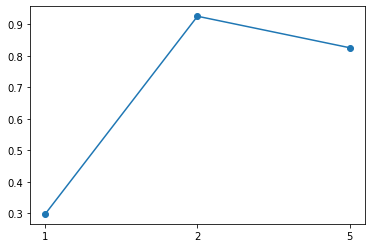


max R squared: 0.9253748651739113
Variable: dem_to_rep_ratio     Importance: 0.46
Variable: avg_ventilator_usage_pt Importance: 0.45
Variable: restaurant.dine.in   Importance: 0.04
Variable: Total!!Population of Two or More Races!!White; American Indian and Alaska Native Importance: 0.04
Variable: Total!!Population of one race!!Some Other Race Importance: 0.01
Variable: stay.at.home         Importance: 0.0
Variable: X.50.gatherings      Importance: 0.0
Variable: X.500.gatherings     Importance: 0.0
Variable: public.schools       Importance: 0.0
Variable: entertainment.gym    Importance: 0.0
Variable: Total!!Male          Importance: 0.0
Variable: Total!!Female        Importance: 0.0
Variable: Total                Importance: 0.0
Variable: Total!!Population of one race Importance: 0.0
Variable: Total!!Population of one race!!White Importance: 0.0
Variable: Total!!Population of one race!!Black or African American Importance: 0.0
Variable: Total!!Population of one race!!American Indian a

In [48]:
km_3 = data[data["label"]==3]
km3_X = km_3.drop(['Unnamed: 0', 'cases_total', 
       'deaths_total', 'cases_per_capita', 'deaths_per_capita',
       'case_fatality_rate', 'num_hospitals', 'num_licensed_beds','num_staffed_beds','num_icu_beds',
        'adult_icu_beds','pedi_icu_beds', 'potential_increase_in_bed_capac','bed_utilization','avg_ventilator_usage',
                 "label", "label_2"], axis=1)
km3_y = km_3["cases_per_capita"]
X_train, X_test, y_train, y_test = train_test_split(km3_X, km3_y, test_size=0.33, random_state=66)
np.random.seed(263)
Bs = [1, 2, 5]
Rsqs = []
for B in Bs:
    regressor4 = RandomForestRegressor(n_estimators=B, max_depth=10)
    regressor4.fit(X_train, y_train)
    Rsqs.append(regressor4.score(X_train, y_train))
# Make the plot
plt.plot(list(map(str, Bs)), Rsqs, "-o")
plt.show()
max_Rsq = max(Rsqs)
max_index = Rsqs.index(max_Rsq)
print("\nmax R squared:", max_Rsq)
B = Bs[max_index]
B
regressor4 = RandomForestRegressor(n_estimators=B, max_depth=10)
regressor4.fit(X_train, y_train)
preds = regressor4.predict(X_test)
feature_list = list(km3_X.columns)
# Get numerical feature importances
importances = list(regressor4.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

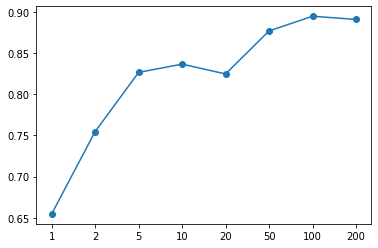


max R squared: 0.8949923893351185
Variable: Total!!Population of one race!!Asian!!Asian Indian Importance: 0.07
Variable: X.50.gatherings      Importance: 0.06
Variable: Total!!Population of one race!!Black or African American Importance: 0.06
Variable: Total!!Population of Two or More Races!!White; Some Other Race Importance: 0.06
Variable: Total!!Population of one race!!Asian!!Vietnamese Importance: 0.04
Variable: Total!!Population of Two or More Races!!White; American Indian and Alaska Native Importance: 0.04
Variable: dem_to_rep_ratio     Importance: 0.03
Variable: entertainment.gym    Importance: 0.03
Variable: Total!!Population of one race!!Asian!!Chinese (including Taiwanese) Importance: 0.03
Variable: Total!!Population of one race!!Asian!!Filipino Importance: 0.03
Variable: Total!!Population of one race!!Asian!!Korean Importance: 0.03
Variable: Total!!Population of one race!!Native Hawaiian and Other Pacific Islander!!Samoan Importance: 0.03
Variable: Total!!Population of one 

In [49]:
full_X = data.drop(['Unnamed: 0', 'cases_total', 
       'deaths_total', 'cases_per_capita', 'deaths_per_capita',
       'case_fatality_rate', 'num_hospitals', 'num_licensed_beds','num_staffed_beds','num_icu_beds',
        'adult_icu_beds','pedi_icu_beds', 'potential_increase_in_bed_capac','bed_utilization','avg_ventilator_usage',
                 "label", "label_2"], axis=1)
full_y = data["cases_per_capita"]
X_train, X_test, y_train, y_test = train_test_split(full_X, full_y, test_size=0.33, random_state=66)
np.random.seed(263)
Bs = [1, 2, 5, 10, 20, 50, 100, 200]
Rsqs = []
for B in Bs:
    regressor5 = RandomForestRegressor(n_estimators=B, max_depth=10)
    regressor5.fit(X_train, y_train)
    Rsqs.append(regressor5.score(X_train, y_train))
# Make the plot
plt.plot(list(map(str, Bs)), Rsqs, "-o")
plt.show()
max_Rsq = max(Rsqs)
max_index = Rsqs.index(max_Rsq)
print("\nmax R squared:", max_Rsq)
B = Bs[max_index]
B
regressor5 = RandomForestRegressor(n_estimators=B, max_depth=10)
regressor5.fit(X_train, y_train)
preds = regressor5.predict(X_test)
feature_list = list(full_X.columns)
# Get numerical feature importances
importances = list(regressor5.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [51]:
kmeans0 = data[data["label"]==0]
kmeans0.columns

Index(['Unnamed: 0', 'dem_to_rep_ratio', 'stay.at.home', 'X.50.gatherings',
       'X.500.gatherings', 'public.schools', 'restaurant.dine.in',
       'entertainment.gym', 'Total!!Male', 'Total!!Female', 'Total',
       'Total!!Population of one race', 'Total!!Population of one race!!White',
       'Total!!Population of one race!!Black or African American',
       'Total!!Population of one race!!American Indian and Alaska Native',
       'Total!!Population of one race!!Asian',
       'Total!!Population of one race!!Asian!!Asian Indian',
       'Total!!Population of one race!!Asian!!Chinese (including Taiwanese)',
       'Total!!Population of one race!!Asian!!Filipino',
       'Total!!Population of one race!!Asian!!Japanese',
       'Total!!Population of one race!!Asian!!Korean',
       'Total!!Population of one race!!Asian!!Vietnamese',
       'Total!!Population of one race!!Asian!!Other Asian',
       'Total!!Population of one race!!Native Hawaiian and Other Pacific Islander',
       '

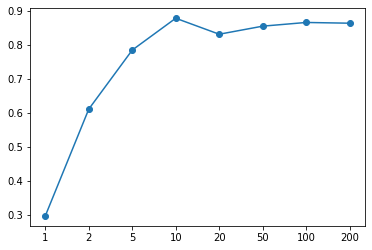


max R squared: 0.877298632116062
Variable: Total!!Population of one race!!Some Other Race Importance: 0.2
Variable: Total!!Population of one race!!Black or African American Importance: 0.12
Variable: Total!!Population of one race!!Asian!!Vietnamese Importance: 0.1
Variable: Total!!Population of one race!!Asian!!Asian Indian Importance: 0.06
Variable: dem_to_rep_ratio     Importance: 0.05
Variable: restaurant.dine.in   Importance: 0.04
Variable: Total!!Population of one race!!Asian!!Filipino Importance: 0.04
Variable: Total!!Population of one race!!Native Hawaiian and Other Pacific Islander Importance: 0.04
Variable: Total!!Population of Two or More Races Importance: 0.03
Variable: mob_parks            Importance: 0.03
Variable: Total!!Population of one race!!American Indian and Alaska Native Importance: 0.02
Variable: Total!!Population of one race!!Asian Importance: 0.02
Variable: Total!!Population of one race!!Asian!!Japanese Importance: 0.02
Variable: Total!!Population of one race!!

In [53]:
em_0 = data[data["label_2"]==0]
em0_X = em_0.drop(['Unnamed: 0', 'cases_total', 
       'deaths_total', 'cases_per_capita', 'deaths_per_capita',
       'case_fatality_rate', 'num_hospitals', 'num_licensed_beds','num_staffed_beds','num_icu_beds',
        'adult_icu_beds','pedi_icu_beds', 'potential_increase_in_bed_capac','bed_utilization','avg_ventilator_usage',
                 "label", "label_2"], axis=1)
em0_y = em_0["cases_per_capita"]
X_train, X_test, y_train, y_test = train_test_split(em0_X, em0_y, test_size=0.33, random_state=66)
np.random.seed(263)
Bs = [1, 2, 5, 10, 20, 50, 100, 200]
Rsqs = []
for B in Bs:
    regressor1 = RandomForestRegressor(n_estimators=B, max_depth=10)
    regressor1.fit(X_train, y_train)
    Rsqs.append(regressor1.score(X_train, y_train))
# Make the plot
plt.plot(list(map(str, Bs)), Rsqs, "-o")
plt.show()
max_Rsq = max(Rsqs)
max_index = Rsqs.index(max_Rsq)
print("\nmax R squared:", max_Rsq)
B = Bs[max_index]
B
regressor1 = RandomForestRegressor(n_estimators=B, max_depth=10)
regressor1.fit(X_train, y_train)
preds = regressor1.predict(X_test)
feature_list = list(em0_X.columns)
# Get numerical feature importances
importances = list(regressor1.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

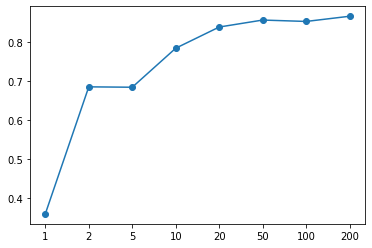


max R squared: 0.8663690197888554
Variable: Total!!Population of one race!!Black or African American Importance: 0.13
Variable: dem_to_rep_ratio     Importance: 0.05
Variable: Total!!Population of Two or More Races!!White; American Indian and Alaska Native Importance: 0.05
Variable: Total!!Population of one race!!Asian!!Filipino Importance: 0.04
Variable: mob_grocery          Importance: 0.04
Variable: mob_parks            Importance: 0.04
Variable: X.500.gatherings     Importance: 0.03
Variable: entertainment.gym    Importance: 0.03
Variable: Total!!Population of one race!!Native Hawaiian and Other Pacific Islander!!Guamanian or Chamorro Importance: 0.03
Variable: Total!!Population of one race!!Native Hawaiian and Other Pacific Islander!!Other Pacific Islander Importance: 0.03
Variable: Total!!Population of one race!!Some Other Race Importance: 0.03
Variable: mob_workplace        Importance: 0.03
Variable: num_hospitals_pt     Importance: 0.03
Variable: stay.at.home         Importanc

In [54]:
em_1 = data[data["label_2"]==1]
em1_X = em_1.drop(['Unnamed: 0', 'cases_total', 
       'deaths_total', 'cases_per_capita', 'deaths_per_capita',
       'case_fatality_rate', 'num_hospitals', 'num_licensed_beds','num_staffed_beds','num_icu_beds',
        'adult_icu_beds','pedi_icu_beds', 'potential_increase_in_bed_capac','bed_utilization','avg_ventilator_usage',
                 "label", "label_2"], axis=1)
em1_y = em_1["cases_per_capita"]
X_train, X_test, y_train, y_test = train_test_split(em1_X, em1_y, test_size=0.33, random_state=66)
np.random.seed(263)
Bs = [1, 2, 5, 10, 20, 50, 100, 200]
Rsqs = []
for B in Bs:
    regressor2 = RandomForestRegressor(n_estimators=B, max_depth=10)
    regressor2.fit(X_train, y_train)
    Rsqs.append(regressor2.score(X_train, y_train))
# Make the plot
plt.plot(list(map(str, Bs)), Rsqs, "-o")
plt.show()
max_Rsq = max(Rsqs)
max_index = Rsqs.index(max_Rsq)
print("\nmax R squared:", max_Rsq)
B = Bs[max_index]
B
regressor2 = RandomForestRegressor(n_estimators=B, max_depth=10)
regressor2.fit(X_train, y_train)
preds = regressor2.predict(X_test)
feature_list = list(em1_X.columns)
# Get numerical feature importances
importances = list(regressor2.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

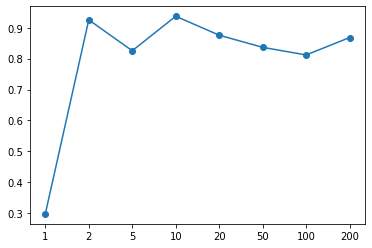


max R squared: 0.9370129957344967
Variable: avg_ventilator_usage_pt Importance: 0.19
Variable: X.500.gatherings     Importance: 0.1
Variable: Total!!Population of one race!!American Indian and Alaska Native Importance: 0.1
Variable: Total!!Population of one race!!Asian!!Vietnamese Importance: 0.1
Variable: Total!!Population of one race!!Native Hawaiian and Other Pacific Islander!!Native Hawaiian Importance: 0.1
Variable: 65-74                Importance: 0.1
Variable: public.schools       Importance: 0.08
Variable: Total!!Population of one race!!Asian!!Korean Importance: 0.08
Variable: Total!!Population of one race!!Native Hawaiian and Other Pacific Islander!!Samoan Importance: 0.08
Variable: Total!!Population of Two or More Races!!White; American Indian and Alaska Native Importance: 0.02
Variable: mob_workplace        Importance: 0.02
Variable: num_staffed_beds_pt  Importance: 0.02
Variable: dem_to_rep_ratio     Importance: 0.0
Variable: stay.at.home         Importance: 0.0
Variable: 

In [55]:
em_2 = data[data["label_2"]==2]
em2_X = em_2.drop(['Unnamed: 0', 'cases_total', 
       'deaths_total', 'cases_per_capita', 'deaths_per_capita',
       'case_fatality_rate', 'num_hospitals', 'num_licensed_beds','num_staffed_beds','num_icu_beds',
        'adult_icu_beds','pedi_icu_beds', 'potential_increase_in_bed_capac','bed_utilization','avg_ventilator_usage',
                 "label", "label_2"], axis=1)
em2_y = em_2["cases_per_capita"]
X_train, X_test, y_train, y_test = train_test_split(em2_X, em2_y, test_size=0.33, random_state=66)
np.random.seed(263)
Bs = [1, 2, 5, 10, 20, 50, 100, 200]
Rsqs = []
for B in Bs:
    regressor3 = RandomForestRegressor(n_estimators=B, max_depth=10)
    regressor3.fit(X_train, y_train)
    Rsqs.append(regressor3.score(X_train, y_train))
# Make the plot
plt.plot(list(map(str, Bs)), Rsqs, "-o")
plt.show()
max_Rsq = max(Rsqs)
max_index = Rsqs.index(max_Rsq)
print("\nmax R squared:", max_Rsq)
B = Bs[max_index]
B
regressor3 = RandomForestRegressor(n_estimators=B, max_depth=10)
regressor3.fit(X_train, y_train)
preds = regressor3.predict(X_test)
feature_list = list(em2_X.columns)
# Get numerical feature importances
importances = list(regressor3.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

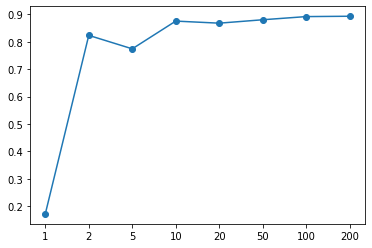


max R squared: 0.893080901753346
Variable: Total!!Population of Two or More Races!!White; American Indian and Alaska Native Importance: 0.19
Variable: Total!!Population of one race!!Asian!!Chinese (including Taiwanese) Importance: 0.1
Variable: Total!!Population of one race!!Native Hawaiian and Other Pacific Islander!!Samoan Importance: 0.1
Variable: Total!!Population of one race!!Asian!!Japanese Importance: 0.06
Variable: Total!!Population of one race!!Native Hawaiian and Other Pacific Islander!!Native Hawaiian Importance: 0.06
Variable: Total!!Population of one race!!Native Hawaiian and Other Pacific Islander!!Other Pacific Islander Importance: 0.04
Variable: Total!!Population of Two or More Races!!White; Some Other Race Importance: 0.04
Variable: mob_residential      Importance: 0.04
Variable: mob_workplace        Importance: 0.03
Variable: Total!!Population of one race!!Asian!!Filipino Importance: 0.02
Variable: Total!!Population of one race!!Asian!!Vietnamese Importance: 0.02
Var

In [56]:
em_3 = data[data["label_2"]==3]
em3_X = em_3.drop(['Unnamed: 0', 'cases_total', 
       'deaths_total', 'cases_per_capita', 'deaths_per_capita',
       'case_fatality_rate', 'num_hospitals', 'num_licensed_beds','num_staffed_beds','num_icu_beds',
        'adult_icu_beds','pedi_icu_beds', 'potential_increase_in_bed_capac','bed_utilization','avg_ventilator_usage',
                 "label", "label_2"], axis=1)
em3_y = em_3["cases_per_capita"]
X_train, X_test, y_train, y_test = train_test_split(em3_X, em3_y, test_size=0.33, random_state=66)
np.random.seed(263)
Bs = [1, 2, 5, 10, 20, 50, 100, 200]
Rsqs = []
for B in Bs:
    regressor4 = RandomForestRegressor(n_estimators=B, max_depth=10)
    regressor4.fit(X_train, y_train)
    Rsqs.append(regressor4.score(X_train, y_train))
# Make the plot
plt.plot(list(map(str, Bs)), Rsqs, "-o")
plt.show()
max_Rsq = max(Rsqs)
max_index = Rsqs.index(max_Rsq)
print("\nmax R squared:", max_Rsq)
B = Bs[max_index]
B
regressor4 = RandomForestRegressor(n_estimators=B, max_depth=10)
regressor4.fit(X_train, y_train)
preds = regressor4.predict(X_test)
feature_list = list(em3_X.columns)
# Get numerical feature importances
importances = list(regressor4.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];